<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Objection%20(car)_Detection%20%26%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import libraries

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image

# graphs
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import random
import cv2
import os
import glob

Using TensorFlow backend.


## Step1: Upload data

#### 1.1 read data from google drive (slow) 
Whenever I make changes to the data, this will also change the data from the google drive. This is not what I want.

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive"

#### 1.2 Copy data from google drive to colab

In [0]:
# Copy data from google to Colab
#!cp -r "/content/drive/My Drive/Deep Learning projects/car segmentation" "/content"

^C


## Step 1: Get familar with the data & visualize the images

#### 1.1 visualize one image with the corresponding labelled image

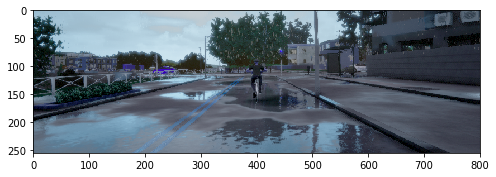

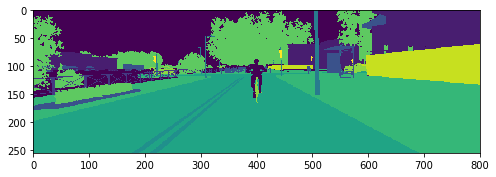

In [0]:
#fig = plt.figure(figsize = (8, 6))
img_RGB = "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/000020.png"
img_Seg = "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/000020.png"
img_RGB_arary = cv2.imread(img_RGB)
img_Seg_arary = cv2.imread(img_Seg)
plt.rcParams['figure.figsize'] = (8, 6)
plt.imshow(img_RGB_arary)
plt.show()
plt.imshow(img_Seg_arary[:, :, 0])
plt.show() 
 

## Step 2: Data Preprocessing

#### 2.1 Combine episode_0001 to episode_0014 for training & testing dataset respectively

In [0]:
# create two files, x_train, y_train to store the original images and labels
#os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/x_train_images")
#os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/y_train_labels")

In [0]:
# move all RGB images to x_train_images
episodes = ["0001/", "0002/", "0003/", "0004/", "0005/", "0006/", "0007/", "0008/", "0009/", "0010/", "0011/", "0012/", "0013/", "0014/"]
for episode in episodes:
  pathes = glob.glob("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:
    try:
      img_array/255
    except:
      print(path)
      break
    head, tail = os.path.split(path)
    new_path = "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/x_train_images/" + head[-22:-10] + "RGB_" + tail
    os.rename(path, new_path)
    #print(new_path)

In [0]:
# move all Seg (labels) to y_train_images
episodes = ["0001/", "0002/", "0003/", "0004/", "0005/", "0006/", "0007/", "0008/", "0009/", "0010/", "0011/", "0012/", "0013/", "0014/"]
for episode in episodes:
  pathes = glob.glob("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    try:
      img_array/255
    except:
      print(path)
      break
    head, tail = os.path.split(path)
    new_path = "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/y_train_labels/" + head[-22:-10] + "Seg_" + tail
    os.rename(path, new_path)
    #print(new_path)

In [0]:
dir_train_images = '/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/x_train_images'
dir_train_labels = '/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/y_train_labels'

dir_train_images_fname = os.listdir(dir_train_images)
dir_train_labels_fname = os.listdir(dir_train_labels)

print("Total training images:", len(dir_train_images_fname))
print("Total training labels:", len(dir_train_labels_fname))

Total training images: 2520
Total training labels: 2519


#### 2.2 Samll dataset (x_train, y_train ) episod_0000 for pilot practice

In [0]:
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/training_imgs")
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/training_labels")

os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part")       
         
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_imgs")
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_imgs/data")
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_labels")
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_labels/data")

# test data & labels
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraRGB/data")
os.mkdir("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraSeg/data")

In [0]:
# Move images and labels to the sub_files
pathes = glob.glob("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/*.png")
for path in pathes[:150]:
  head, tail = os.path.split(path)
  #print(head)
  #print(tail)
  img_array = cv2.imread(path)
  try:
    img_array/255
  except:
    print(path)
    break
  new_path = head + '/training_imgs/' + tail
  os.rename(path, new_path)

# Move the rest 30 images for validation
for path in pathes[150:]:
  head, tail = os.path.split(path)
  img_array = cv2.imread(path)
  try:
    img_array/255
  except:
    print(path)
    break
  #print(head)
  #print(tail)
  new_path = "/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_imgs/data/" + tail
  os.rename(path, new_path)

In [0]:
img_array = cv2.imread("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/000149.png")
print(img_array.shape)

(256, 800, 3)


In [0]:
# Move images and labels to the sub_files
pathes = glob.glob("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/*.png")
for path in pathes[:150]:
  head, tail = os.path.split(path)
  #print(head)
  #print(tail)
  img_array = cv2.imread(path)
  try:
    img_array/255
  except:
    print(path)
    break
  new_path = head + '/training_labels/' + tail
  os.rename(path, new_path)
  
for path in pathes[150:]:
  head, tail = os.path.split(path)
  img_array = cv2.imread(path)
  try:
    img_array/255
  except:
    print(path)
    break
  #print(head)
  #print(tail)
  new_path = "/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_labels/data/" + tail
  os.rename(path, new_path)

In [0]:
# Move test images to the sub_files
pathes = glob.glob("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraRGB/*.png")
for path in pathes:
  head, tail = os.path.split(path)
  new_path = head + '/data/' + tail
  os.rename(path, new_path)

# Move test labels to the sub_files
pathes = glob.glob("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraSeg/*.png")
for path in pathes:
  head, tail = os.path.split(path)
  new_path = head + '/data/' + tail
  os.rename(path, new_path)

#### Data Augumentation

In [0]:
# Creating the training Image and Mask generator

batch_size = 4

train_datagen = ImageDataGenerator(rescale = 1/255.) # shear_range = 0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect'

#mask_datagen = image.ImageDataGenerator()

train_image_generator = train_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/", 
                       batch_size = batch_size, target_size = (256, 800), class_mode=None) # target_size = (img_size, img_size), shuffle = True

train_mask_generator = train_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/", 
                       batch_size = batch_size, target_size = (256, 800),color_mode = "grayscale", class_mode=None) # target_size = (img_size, img_size), shuffle = True

# Creating the validation Image and Mask generator
val_datagen = ImageDataGenerator(rescale = 1/255.)

val_image_generator = val_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_imgs",
                      batch_size = batch_size, target_size = (256, 800), class_mode=None)
val_mask_generator = val_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_labels",
                      batch_size = batch_size, target_size = (256, 800), color_mode = "grayscale", class_mode=None)


test_datagen = ImageDataGenerator(rescale = 1/255.) 
test_image_generator = test_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraRGB",
                      batch_size = batch_size, target_size = (256, 800), class_mode=None)

test_mask_generator = test_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraSeg",
                      batch_size = batch_size, target_size = (256, 800), color_mode = "grayscale", class_mode=None)


train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 480 images belonging to 1 classes.
Found 480 images belonging to 1 classes.


(4, 256, 800, 3)


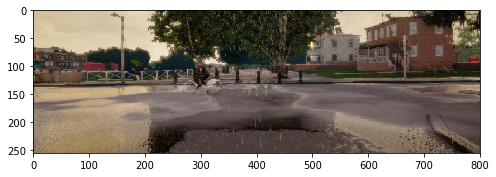

In [0]:
# check generator
for img in train_image_generator:
  print(img.shape)
  plt.imshow(img[0])
  break

In [0]:
# check generator

count = 0
for x,y in train_generator:
  count += 1
  print(x.shape, y.shape)
  print(count)
  break
  if count % 100 == 0:
    print(count)

(4, 256, 256, 3) (4, 256, 256, 3)
1


(256, 800, 3)


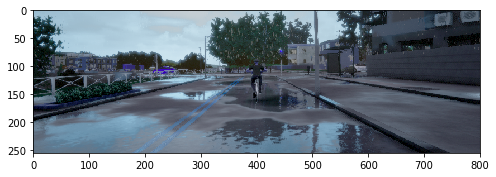

In [0]:
tmp = cv2.imread('/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/training_imgs/000020.png')
print(tmp.shape)
plt.imshow(tmp)

#### Creating data generator

In [0]:
def data_gen(img_folder, mask_folder, batch_size):
  c = 0
  n = os.listdir(img_folder) # List of training images
  random.shuffle(n)
  
  while (True):
    img = np.zeros((batch_size, 256, 800, 3)).astype('float')
    mask = np.zeros((batch_size, 256, 800, 1)).astype('float')
    
    for i in range(c, c + batch_size): # initially from 0 to 16, c = 0
      train_img = cv2.imread(img_folder + '/' + n[i])/255.
      #train_img = cv2.resize(train_img, (512, 512)) # Read an image from folder and resize the image
      
      img[i-c] = train_img # add to array -img[0], img[1], and so on
      
      train_mask = cv2.imread(mask_folder + '/' + n[i], cv2.IMREAD_GRAYSCALE)/255.
      #train_mask = cv2.resize(train_mask, (512, 512))
      train_mask = train_mask.reshape(256, 800, 1) # Add extra dimension for the parity with train_img
      
      mask[i-c] = train_mask
      
    c += batch_size
    if (c + batch_size >= len(os.listdir(img_folder))):
      c = 0
      random.shuffle(n)
    yield img, mask
    
train_frame_path = '/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/training_imgs' 
train_mask_path = '/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/training_labels' 

val_frame_path = '/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_imgs/data' 
val_mask_path = '/content/drive/My Drive/Deep Learning projects/car segmentation/validation data part/validation_labels/data'

# train the model
train_gen = data_gen(train_frame_path, train_mask_path, batch_size = 4)
val_gen = data_gen(val_frame_path, val_mask_path, batch_size = 4)

In [0]:
# remove the images not correct
# !rm "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/._000020.png"

## Step 3: Prepare for the U-Net Model

#### 3.1 Model creation

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
im_height = 256
im_width = 800

input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 800, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 256, 800, 16) 64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 256, 800, 16) 0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_78 

#### 3.2 Model visualization

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

#### 3.3 Model fitting/training

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-car-detection.h5', verbose=1, save_best_only=True, save_weights_only=True)]

In [0]:
#steps_per_epoch = train_image_generator.n//train_image_generator.batch_size
#validation_steps = val_image_generator.n//val_image_generator.batch_size

history = model.fit_generator(train_generator, 
                              epochs = 100, 
                              steps_per_epoch = 35,  # number of training_images / batch_size
                              validation_data = val_generator,
                              validation_steps = 7)

model.save('model-car-detection.h5')

Epoch 1/100
35/35 [==============================] - 16s 459ms/step - loss: 0.1013 - acc: 0.1920 - val_loss: 0.0852 - val_acc: 0.1465
Epoch 2/100
35/35 [==============================] - 14s 409ms/step - loss: 0.1014 - acc: 0.1903 - val_loss: 0.0857 - val_acc: 0.1436
Epoch 3/100
35/35 [==============================] - 14s 410ms/step - loss: 0.1012 - acc: 0.1933 - val_loss: 0.0860 - val_acc: 0.1476
Epoch 4/100
35/35 [==============================] - 14s 409ms/step - loss: 0.1012 - acc: 0.1884 - val_loss: 0.0849 - val_acc: 0.1489
Epoch 5/100
35/35 [==============================] - 14s 409ms/step - loss: 0.1019 - acc: 0.1909 - val_loss: 0.0856 - val_acc: 0.1441
Epoch 6/100
35/35 [==============================] - 14s 409ms/step - loss: 0.1010 - acc: 0.1947 - val_loss: 0.0871 - val_acc: 0.1433
Epoch 7/100
35/35 [==============================] - 14s 409ms/step - loss: 0.1013 - acc: 0.1892 - val_loss: 0.0856 - val_acc: 0.1511
Epoch 8/100
35/35 [==============================] - 14s 411ms

## Step 4: Model accuracy & loss analysis

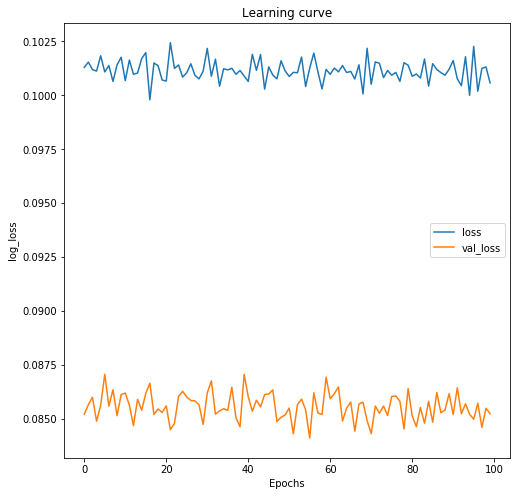

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
#plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

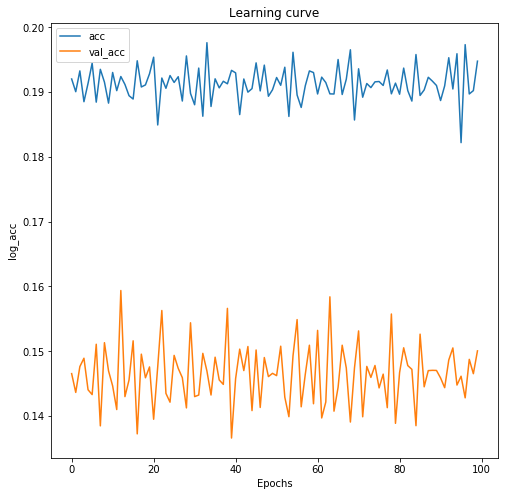

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["acc"], label="acc")
plt.plot(history.history["val_acc"], label="val_acc")
#plt.plot( np.argmin(history.history["val_acc"]), np.min(history.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_acc")
plt.legend();

## Step 5: Inference With the Model

In [0]:
# Load best model
model.load_weights('model-car-detection.h5')

In [0]:
# Evaluate on validation set (this must be equals to the best log_loss)
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
model.evaluate_generator(generator = test_generator, steps = STEP_SIZE_TEST)

[0.11148941305776437, 0.13099361192435027]

In [0]:
# Predict on train, val and test
preds_train = model.predict_generator(train_image_generator, steps = train_image_generator.n, verbose=1)
preds_val = model.predict_generator(val_image_generator, steps = val_image_generator.n, verbose=1)
preds_test = model.predict_generator(test_image_generator, steps = test_image_generator.n, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_val > 0.5).astype(np.uint8)

480/480 [==============================] - 58s 120ms/step


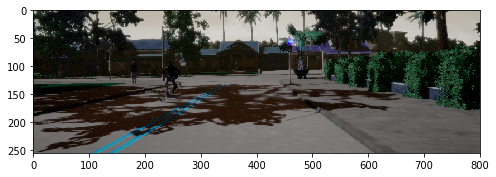

In [0]:
# True image
plt.imshow(img_array)

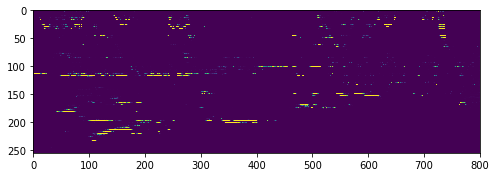

In [0]:
# predicted
img_array = cv2.imread("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraRGB/data/000020.png")
res = model.predict(np.array([img_array]))
res.shape
plt.imshow(res[0][:,:, 0])


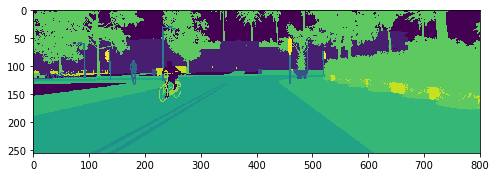

In [0]:
# ground Truth
img_array = cv2.imread("/content/drive/My Drive/Deep Learning projects/car segmentation/_out_test_crop_800_256/episode_0000/CameraSeg/data/000020.png")
plt.imshow(img_array[:,:,0])

## Useful reference
URL_1 = "https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a"

URL_2 = "https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/"

URL_3 = "https://tryolabs.com/blog/2017/08/30/object-detection-an-overview-in-the-age-of-deep-learning/" **(include datasets)**

URL_4 = "https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/"

URL_5 = "https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9" **(Deep learning for object Detection)**

URL_6 = "https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9"

URL_7 = "https://www.depends-on-the-definition.com/unet-keras-segmenting-images/" **(unet model)**

URL_8 = "https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d" **(model with ImageDataGenerator)**